In [33]:
%load_ext autoreload
%autoreload 2

# import ST_utils
# import train_STAligner
import sys
sys.path.append('/home/liwb/project/rna2adt')

import STAligner
import train_STAligner
import ST_utils

import warnings
warnings.filterwarnings("ignore")

# # the location of R (used for the mclust clustering)
# import os
# os.environ['R_HOME'] = "/home/xzhou/anaconda3/envs/PyG/lib/R"
# os.environ['R_USER'] = "/home/xzhou/anaconda3/envs/PyG/lib/python3.8/site-packages/rpy2"
# import rpy2.robjects as robjects
# import rpy2.robjects.numpy2ri

import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import scipy.sparse as sp
import scipy.linalg
from scipy.sparse import csr_matrix
import random

import torch
seed = 3407
torch.manual_seed(seed) # 为CPU设置随机种子
torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.	
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
used_device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')

from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import fowlkes_mallows_score as FMI
from sklearn.metrics import silhouette_score as SC

from utils import find_resolution, find_res_label

from sklearn.cluster import KMeans

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
data_name = "cross_species"
label_key = 'cluster_s'
batch_key = 'batch_id'
section_keys  = ['Rheus_macaques_ifgn', 'Human_ifgn']
# section_ids = ['Human_with_h1n1', 'Human_ifgn', 'Cynomolgus_monkeys_ifgn', 'Rheus_macaques_ifgn']

refdata = sc.read_h5ad(f'/home/chenhc/project/rna2adt/A_run_test/data/{data_name}/ADT.h5ad')
# /home/chenjn/rna2adt/data/SCoPE2/ADT.h5ad

adata = sc.read_h5ad(f'/home/chenhc/project/rna2adt/A_run_test/new_emb_sc/{data_name}.h5ad')
# adata = sc.read_h5ad(f'/home/chenjn/rna2adt_fork/A_run_test/data/{data_name}/ADT.h5ad')
adata.obs = refdata.obs
# adata = ad.AnnData(adata, obs=refdata.obs)

In [45]:
index = [i in section_keys for i in refdata.obs[batch_key]]
refdata = refdata[index]
print(refdata)

index = [i in section_keys for i in adata.obs[batch_key]]
adata = adata[index]
print(adata)

View of AnnData object with n_obs × n_vars = 22955 × 38
    obs: 'sample', 'cluster_o', 'cluster_s', 'batch_id'
    uns: 'name'
View of AnnData object with n_obs × n_vars = 22955 × 256
    obs: 'sample', 'cluster_o', 'cluster_s', 'batch_id'
    uns: 'louvain', 'neighbors'
    obsp: 'connectivities', 'distances'


In [46]:
# sc.pp.neighbors(refdata)

# sc.tl.louvain(refdata)
# refdata.obs['louvain_res'] = find_res_label(refdata, len(np.unique(adata.obs[label_key])))
# sc.tl.umap(refdata)

# sc.pl.umap(refdata, color=[batch_key, label_key], ncols=2, wspace=0.4, show=True)
# sc.pl.umap(refdata, color=['louvain', 'louvain_res'], ncols=2, wspace=0.4, show=True)

# print(ARI(refdata.obs['louvain'], refdata.obs[label_key]))
# print(NMI(refdata.obs['louvain'], refdata.obs[label_key])) 
# print(FMI(refdata.obs['louvain'], refdata.obs[label_key]))
# print()
# print(ARI(refdata.obs['louvain_res'], refdata.obs[label_key]))
# print(NMI(refdata.obs['louvain_res'], refdata.obs[label_key])) 
# print(FMI(refdata.obs['louvain_res'], refdata.obs[label_key]))

In [47]:
# sc.pp.neighbors(adata)

# sc.tl.louvain(adata)
# adata.obs['louvain_res'] = find_res_label(adata, len(np.unique(adata.obs[label_key])))
# sc.tl.umap(adata)

# sc.pl.umap(adata, color=[batch_key, label_key], ncols=2, wspace=0.4, show=True)
# sc.pl.umap(adata, color=['louvain', 'louvain_res'], ncols=2, wspace=0.4, show=True)

# print(ARI(adata.obs['louvain'], adata.obs[label_key]))
# print(NMI(adata.obs['louvain'], adata.obs[label_key])) 
# print(FMI(adata.obs['louvain'], adata.obs[label_key]))
# print()
# print(ARI(adata.obs['louvain_res'], adata.obs[label_key]))
# print(NMI(adata.obs['louvain_res'], adata.obs[label_key])) 
# print(FMI(adata.obs['louvain_res'], adata.obs[label_key]))

In [48]:
Batch_list = []
adj_list = []
section_ids = section_keys

adata.obs_names = [x + '_' + y + '_' + z for x, y, z in zip(adata.obs_names, adata.obs[batch_key], adata.obs[label_key])]  

for section_id in section_ids:
    tmpdata = adata[adata.obs[batch_key] == section_id]
    # tmpdata.X = csr_matrix(tmpdata.X)
    # adata.var_names_make_unique(join="++")

    # make spot name unique
    # tmpdata.obs_names = [x + '_' + section_id + '_' + y for x, y in zip(tmpdata.obs_names, tmpdata.obs['celltype.l2'])]  
    # adata.obs_names = [x + '_' + section_id for x in adata.obs_names]  
    # print(tmpdata.obs_names)  
    
    # Constructing the spatial network
    ST_utils.Cal_Spatial_Net(tmpdata, k_cutoff=20, model='KNN') # the spatial network are saved in adata.uns[‘adj’]
    # ST_utils.Stats_Spatial_Net(adata) # plot the number of spatial neighbors
       
    # Normalization
    # sc.pp.highly_variable_genes(tmpdata, flavor="seurat_v3", n_top_genes=10000)
    # sc.pp.normalize_total(tmpdata)
    # sc.pp.log1p(tmpdata)

    # adata = adata[:, adata.var['highly_variable']]
    adj_list.append(tmpdata.uns['adj'])
    Batch_list.append(tmpdata)

------Calculating spatial graph...
The graph contains 226120 edges, 11306 cells.
20.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 232980 edges, 11649 cells.
20.0000 neighbors per cell on average.


In [49]:
# iter_comb is used to specify the order of integration. For example, (0, 1) means slice 0 will be algined with slice 1 as reference.
iter_comb = [(i, i + 1) for i in range(len(section_keys) - 1)]

# Here, to reduce GPU memory usage, each slice is considered as a subgraph for training.
adata_af = train_STAligner.train_STAligner_subgraph(adata, verbose=True, knn_neigh = 10,
                                                    n_epochs = 3000, iter_comb = iter_comb, 
                                                    Batch_list=Batch_list, device=used_device,
                                                    margin=0.01, batch_key=batch_key, label_key=label_key)



AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Sigmoid()
  )
)
Train with STAligner...


  0%|          | 0/3000 [00:00<?, ?it/s]

Update spot triplets at epoch 0


100%|██████████| 3000/3000 [03:14<00:00, 15.41it/s, loss=0.503, mseloss=0.00332]


In [50]:
adata1 = ad.AnnData(adata_af.obsm['STAligner'], obs=adata_af.obs)
adata2 = ad.AnnData(adata_af.obsm['STAligner_o'], obs=adata_af.obs)

In [51]:
section_ids = np.array(adata.obs[batch_key].unique())
section_ids

array(['Human_ifgn', 'Rheus_macaques_ifgn'], dtype=object)

In [52]:
sc.pp.neighbors(adata1)
sc.tl.louvain(adata1)
adata1.obs['louvain_res'] = find_res_label(adata1, len(np.unique(adata1.obs[label_key])))

         Falling back to preprocessing with `sc.pp.pca` and default params.


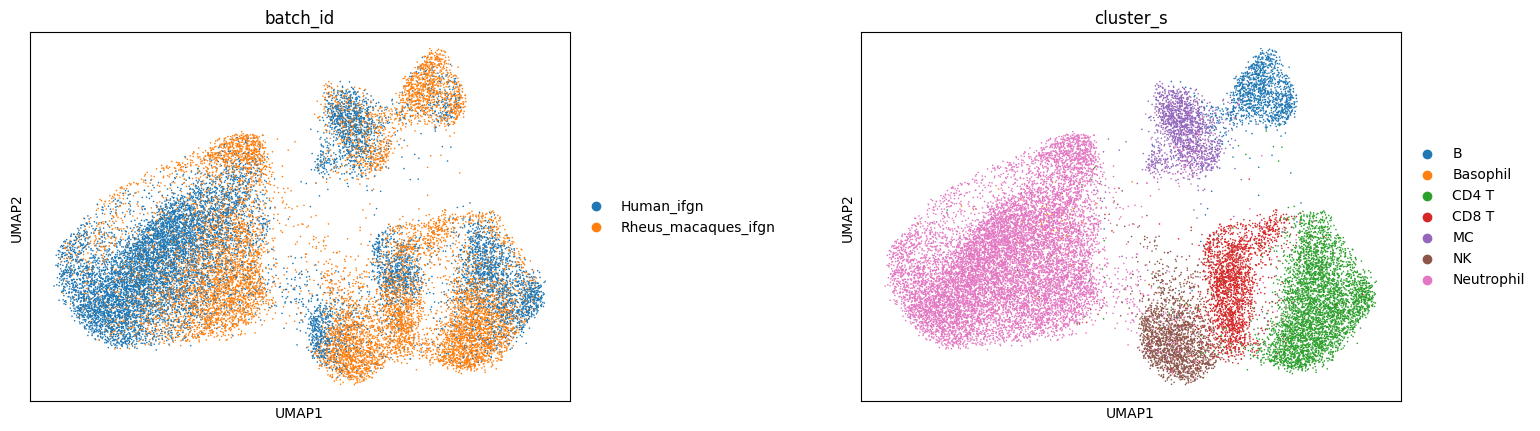

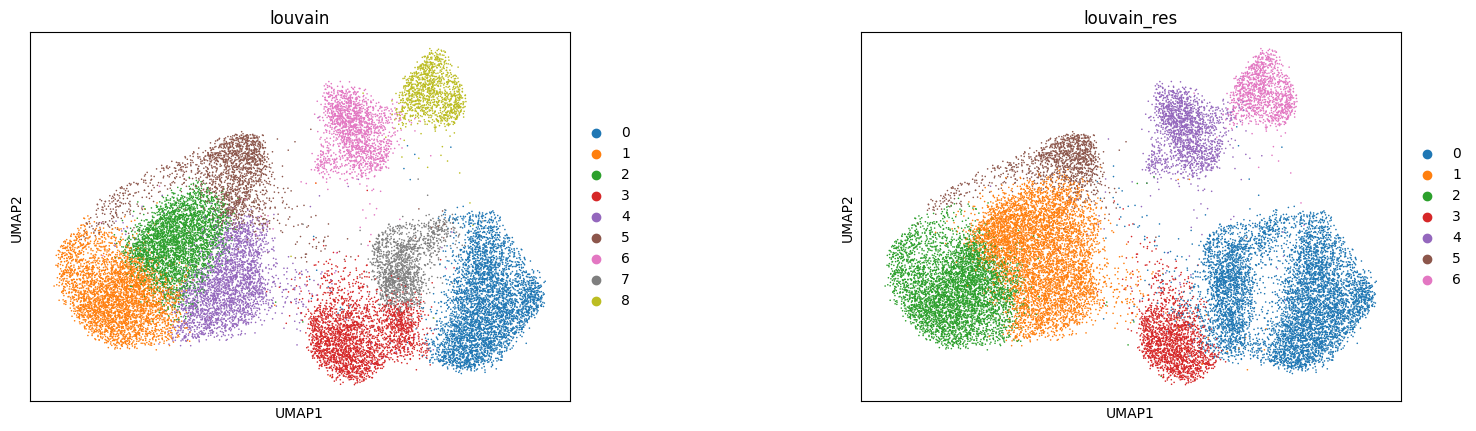

0.4143379025488402
0.6824446912355935
0.5763801840959517

0.47431180543608126
0.6871153132676723
0.6200815616502202


In [53]:
sc.tl.umap(adata1)
sc.pl.umap(adata1, color=[batch_key, label_key], ncols=2, wspace=0.4, show=True)
sc.pl.umap(adata1, color=['louvain', 'louvain_res'], ncols=2, wspace=0.4, show=True)

print(ARI(adata1.obs['louvain'], adata1.obs[label_key]))
print(NMI(adata1.obs['louvain'], adata1.obs[label_key]))
print(FMI(adata1.obs['louvain'], adata1.obs[label_key]))
print()
print(ARI(adata1.obs['louvain_res'], adata1.obs[label_key]))
print(NMI(adata1.obs['louvain_res'], adata1.obs[label_key])) 
print(FMI(adata1.obs['louvain_res'], adata1.obs[label_key]))